In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
else:
    print(f'Found GPU at: {device_name}')

# Alternative way to check
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [2]:
!pip install tensorflow-addons

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [3]:
!pip install transformers


# **PART 2**

In [4]:
!!pip install datasets

['Requirement already satisfied: datasets in /opt/conda/lib/python3.10/site-packages (3.0.1)',
 'Requirement already satisfied: filelock in /opt/conda/lib/python3.10/site-packages (from datasets) (3.15.1)',
 'Requirement already satisfied: numpy>=1.17 in /opt/conda/lib/python3.10/site-packages (from datasets) (1.26.4)',
 'Requirement already satisfied: pyarrow>=15.0.0 in /opt/conda/lib/python3.10/site-packages (from datasets) (16.1.0)',
 'Requirement already satisfied: dill<0.3.9,>=0.3.0 in /opt/conda/lib/python3.10/site-packages (from datasets) (0.3.8)',
 'Requirement already satisfied: pandas in /opt/conda/lib/python3.10/site-packages (from datasets) (2.2.2)',
 'Requirement already satisfied: requests>=2.32.2 in /opt/conda/lib/python3.10/site-packages (from datasets) (2.32.3)',
 'Requirement already satisfied: tqdm>=4.66.3 in /opt/conda/lib/python3.10/site-packages (from datasets) (4.66.4)',
 'Requirement already satisfied: xxhash in /opt/conda/lib/python3.10/site-packages (from data

In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np
from sklearn.metrics import classification_report
import torch

from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

from datasets import load_dataset

# Load the Tamil NER dataset
dataset = load_dataset("google/xtreme", "PAN-X.ta")
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Preprocessing the dataset to align NER tags with tokens
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    previous_word_id = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append(-100)  # Ignore these tokens in the loss
        elif word_id != previous_word_id:
            new_labels.append(labels[word_id])  # Only label first token of the word
        else:
            # Continue with I- tags for inner tokens, otherwise ignore
            new_labels.append(labels[word_id] if label_list[labels[word_id]].startswith("I-") else -100)
        previous_word_id = word_id
    return new_labels


def preprocess_data(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    all_word_ids = [tokenized_inputs.word_ids(i) for i in range(len(batch["tokens"]))]

    # Align labels with word ids for each example in the batch
    all_aligned_labels = [
        align_labels_with_tokens(labels, word_ids) for labels, word_ids in zip(batch["ner_tags"], all_word_ids)
    ]

    # Add aligned labels to tokenized inputs
    tokenized_inputs["labels"] = all_aligned_labels
    return tokenized_inputs


train_dataset = train_data.map(preprocess_data, batched=True)
validation_dataset = validation_data.map(preprocess_data, batched=True)
test_dataset = test_data.map(preprocess_data, batched=True)



Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Load the model with more capacity for multilingual tasks
model = AutoModelForTokenClassification.from_pretrained("xlm-roberta-large", num_labels=dataset['train'].features['ner_tags'].feature.num_classes)


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.221500,0.462139
2,0.260600,0.311557
3,0.158500,0.323248


TrainOutput(global_step=5625, training_loss=0.2380635491265191, metrics={'train_runtime': 2428.1501, 'train_samples_per_second': 18.533, 'train_steps_per_second': 2.317, 'total_flos': 1.044813078144e+16, 'train_loss': 0.2380635491265191, 'epoch': 3.0})

In [14]:
# Evaluation
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.3404061198234558, 'eval_runtime': 13.0913, 'eval_samples_per_second': 76.387, 'eval_steps_per_second': 9.548, 'epoch': 3.0}


In [18]:
!pip install seqeval


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=16fa555e811ced18ab15faaa861efcb4c12cf4f3573c36446f74165e4ba0cbfa
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [19]:
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

# Define compute_metrics function
def compute_metrics(pred):
    label_ids = pred.label_ids
    predictions = pred.predictions.argmax(-1)
    
    # Remove ignored index (special tokens)
    true_labels = [[label_list[label_id] for (label_id, pred_id) in zip(label_ids[i], predictions[i]) if label_id != -100]
                   for i in range(len(label_ids))]
    true_predictions = [[label_list[pred_id] for (label_id, pred_id) in zip(label_ids[i], predictions[i]) if label_id != -100]
                        for i in range(len(predictions))]
    
    # Calculate metrics using seqeval
    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    accuracy = accuracy_score(true_labels, true_predictions)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

# Update Trainer to include the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

import pandas as pd
from transformers import Trainer, TrainingArguments

# Run evaluation on test dataset
metrics = trainer.evaluate(test_dataset)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([metrics])

# Display the DataFrame
print(metrics_df)



/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


   eval_loss  eval_model_preparation_time  eval_accuracy  eval_precision  \
0   0.340406                       0.0103       0.915019        0.672924   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0     0.751007  0.709825       13.6435                   73.295   

   eval_steps_per_second  
0                  9.162  


In [20]:
metrics_df

,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.340406,0.0103,0.915019,0.672924,0.751007,0.709825,13.6435,73.295,9.162


In [29]:
import logging
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from torch.optim import AdamW

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)  # Suppress warnings

# Define data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define layer-wise learning rate decay function without pooler layer for XLM-Roberta
def get_optimizer(model):
    base_lr = 2e-5  # Base learning rate
    layerwise_decay = 0.9  # Decay factor

    optimizer_grouped_parameters = []
    # Apply LLRD on XLM-Roberta encoder layers
    for i, layer in enumerate(model.roberta.encoder.layer):
        layer_lr = base_lr * (layerwise_decay ** (len(model.roberta.encoder.layer) - i - 1))
        optimizer_grouped_parameters.append({"params": layer.parameters(), "lr": layer_lr})
    
    # Apply base learning rate for classifier head
    optimizer_grouped_parameters.append({"params": model.classifier.parameters(), "lr": base_lr})
    
    # Initialize AdamW optimizer with weight decay
    return AdamW(optimizer_grouped_parameters, lr=base_lr, weight_decay=0.01)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
)

# Trainer setup with custom optimizer and LLRD
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(get_optimizer(model), None)  # Custom optimizer with LLRD

)

trainer.train()

# Run evaluation on test dataset and display metrics as DataFrame
import pandas as pd

metrics = trainer.evaluate(test_dataset)
metrics_df = pd.DataFrame([metrics])
metrics_df


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.015300,0.642593,0.918812,0.671273,0.756557,0.711368
2,0.056900,0.526202,0.919715,0.681519,0.764754,0.720742
3,0.084100,0.519583,0.924411,0.704663,0.780328,0.740568


,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.559198,0.920347,0.690663,0.780822,0.73298,13.6058,73.498,9.187,3.0


In [38]:
# Inspect the log history to understand the structure of logs
for log in trainer.state.log_history:
    print(log)


{'loss': 0.0271, 'grad_norm': 1.2069847583770752, 'learning_rate': 1.6150242795811236e-06, 'epoch': 0.26666666666666666, 'step': 500}
{'loss': 0.0204, 'grad_norm': 0.1547384411096573, 'learning_rate': 1.4574609352317458e-06, 'epoch': 0.5333333333333333, 'step': 1000}
{'loss': 0.0153, 'grad_norm': 3.9723548889160156, 'learning_rate': 1.2998975908823678e-06, 'epoch': 0.8, 'step': 1500}
{'eval_loss': 0.6425928473472595, 'eval_accuracy': 0.9188115235256932, 'eval_precision': 0.6712727272727272, 'eval_recall': 0.7565573770491804, 'eval_f1': 0.7113680154142581, 'eval_runtime': 13.6506, 'eval_samples_per_second': 73.257, 'eval_steps_per_second': 9.157, 'epoch': 1.0, 'step': 1875}
{'loss': 0.0246, 'grad_norm': 8.023499488830566, 'learning_rate': 1.14233424653299e-06, 'epoch': 1.0666666666666667, 'step': 2000}
{'loss': 0.0684, 'grad_norm': 59.389732360839844, 'learning_rate': 9.84770902183612e-07, 'epoch': 1.3333333333333333, 'step': 2500}
{'loss': 0.0511, 'grad_norm': 9.32300090789795, 'learni

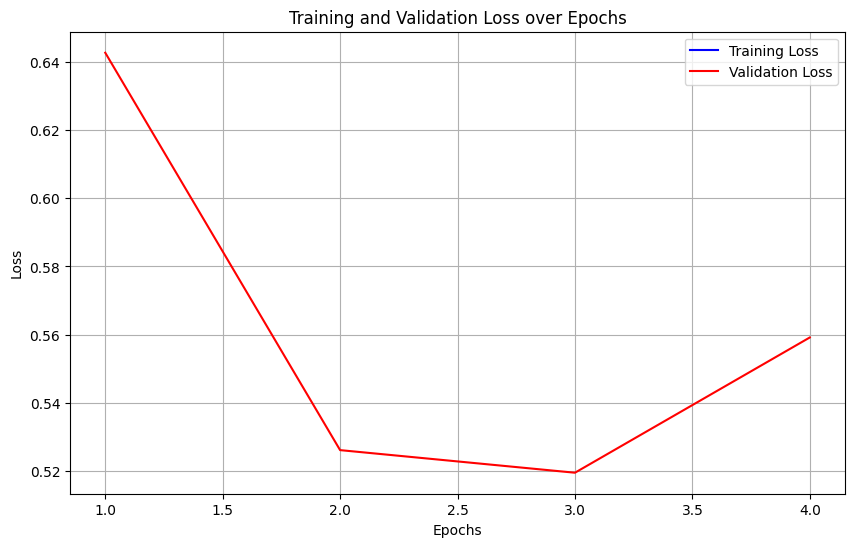

In [40]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
train_losses = []
eval_losses = []

# Iterate through the log history and collect losses
for log in trainer.state.log_history:
    # Collect training loss only at the last step of each epoch
    if "loss" in log and "epoch" in log and log["epoch"].is_integer():
        train_losses.append(log["loss"])
    
    # Collect evaluation loss at the end of each epoch
    if "eval_loss" in log and "epoch" in log and log["epoch"].is_integer():
        eval_losses.append(log["eval_loss"])

# Check if train_losses and eval_losses have the same length
if len(train_losses) != len(eval_losses):
    print(f"Warning: Number of eval_losses ({len(eval_losses)}) does not match number of train_losses ({len(train_losses)})")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
def test_model(sentences):
    # Set the model to evaluation mode
    model.eval()
    
    for sentence in sentences:
        # Tokenize the input sentence
        tokenized_input = tokenizer(sentence, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        
        # Move input tensors to the appropriate device (CPU or GPU)
        input_ids = tokenized_input["input_ids"].to(model.device)  # Ensure input is on the correct device
        attention_mask = tokenized_input["attention_mask"].to(model.device)

        # Make predictions using the model
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        
        # Get predictions and convert logits to labels
        predictions = np.argmax(outputs.logits.cpu().numpy(), axis=2)  # Move logits to CPU if necessary

        # Align tokens with predictions
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())  # Ensure tokens are on CPU
        predicted_labels = [label_list[p] for p in predictions[0]]

        # Print the results
        print(f"\nTesting sentence: {sentence}")
        for token, label in zip(tokens, predicted_labels):
            if token not in tokenizer.special_tokens_map.values() and token.strip():  # Skip special tokens and empty tokens
                print(f"Word: '{token}', Predicted Label: {label}")

# Example sentences for testing
test_sentences = [
    "என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.",
    "இது ஒரு புதிய தொழில்நுட்ப மேம்பாடு.",
    "தமிழ் மொழி தமிழ்நாட்டின் நிலையான மொழியாகும்.",
    "இத்தாவரம் சீனா, இந்தியா, ஜப்பான், பப்பாசியா, மைக்குரோனீசியா போன்ற நாடுகளில் காணப்படுகிறது.",
    "சைஃப் அலி கான், தீபிகா படுகோண், ஜான் ஆபிரகாம் (நடிகர்), ஜாக்குலின் பெர்னாண்டஸ், அனில் கபூர், அமீஷா பட்டேல், மற்றும் ரஜினிகாந்த் ஆகியோர்."
]

# Test the model
test_model(test_sentences)



Testing sentence: என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.
Word: 'என்', Predicted Label: O
Word: 'பெயர்', Predicted Label: O
Word: 'வ', Predicted Label: B-PER
Word: '##ின்', Predicted Label: I-PER
Word: '##ஸ்', Predicted Label: I-PER
Word: '##டன்', Predicted Label: I-PER
Word: 'ச', Predicted Label: I-PER
Word: '##ர்', Predicted Label: I-PER
Word: '##ச்சி', Predicted Label: I-PER
Word: '##ல்', Predicted Label: I-PER
Word: 'மற்றும்', Predicted Label: O
Word: 'ந', Predicted Label: B-ORG
Word: '##ான்', Predicted Label: I-ORG
Word: 'க', Predicted Label: I-ORG
Word: '##ோ', Predicted Label: I-ORG
Word: '##யம்', Predicted Label: I-ORG
Word: '##பு', Predicted Label: I-ORG
Word: '##த்த', Predicted Label: I-ORG
Word: '##ூரி', Predicted Label: I-ORG
Word: '##ல்', Predicted Label: I-ORG
Word: 'வ', Predicted Label: O
Word: '##ரு', Predicted Label: I-PER
Word: '##கி', Predicted Label: I-PER
Word: '##ற', Predicted Label: I-PER
Word: '##ே', Predicted Label: I-PER
Word: '##